In [2]:
## Initialization and imports
import pandas as pd 
import numpy as np 

## Changing directory to top folder (All programs run from top)
import os
os.chdir('/Users/nschumacher/docs/galvanize/smunch-user-food-analysis')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib import pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'

## Set random seed
np.random.seed(seed=14)

In [3]:
## Read in pickle data
ing_freq = pd.read_pickle("pickle/user_f_df_tot.p")
ing_freq.sample(3)
customers = ing_freq.cust_id

In [4]:
ing_freq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7149 entries, 0 to 7148
Columns: 987 entries, tahini to cust_id
dtypes: float64(986), object(1)
memory usage: 53.9+ MB


In [5]:
## Function converts inngredients to sudo categories to try and get better sense
## of the clusters. If convert function is not run then does on individual ingredients.
def convert(df):
    convert = pd.read_csv('data/ing_to_cat.csv')
    convert = convert.dropna()

    new_df = pd.DataFrame(columns=convert.category.unique())

    d = pd.Series(convert.category.values, convert.ing.values).to_dict()

    for col in df.columns:
        if col in d.keys():
            new_col = d[col]
            vals = df[col].values

            if len(new_df[new_col].values) < 1 or (new_df[new_col].isnull().values.sum() > 2):
                new_df[new_col] = vals
            else:
                vs = new_df[new_col].values
                new_df[new_col] = vs+vals


    return new_df

ing_freq = convert(ing_freq)

In [6]:
## Need to scale the features for clustering (distance metric)
def scale_df(df):
    for col in df.columns:
        if col != 'cust_id':
            df[col] = (df[col] - df[col].mean())/df[col].std()
    return df
        
ing_freq = scale_df(ing_freq)

In [7]:
# ## Exploring which ingredients are the most and least used
# cols = ing_freq.columns
# ing_means = ing_freq[cols].mean()  ## The variance in frequency would indicate strong preferences on ingredient
# top_ings = ing_means.sort_values().index.values[:]  ## Choosing the x ingredients with the most variance

top_ing_f = ing_freq.copy()
top_ing_f.head(4)

,savory sauce,spice,meat,veg,sweet sauce,alc,herb,pork,grain,sauce,...,sour,wheat,octopus,falafel,noodle,hummus,paste,df cream,salmon,df cheese
0,0.227368,-1.524717,-0.168682,-0.350080,-0.519450,-0.854928,-0.039802,-0.783142,0.933438,-0.515465,...,-0.679498,-0.458834,-0.188921,-0.808132,-0.378434,-0.043346,-0.031493,-0.049172,-0.07258,-0.106149
1,-0.326999,-1.092211,-0.168682,0.359463,-0.519450,-0.714043,-0.121570,-0.409695,1.171849,-0.303438,...,1.363647,1.071817,-0.188921,0.759308,-0.378434,-0.043346,-0.031493,-0.049172,-0.07258,-0.106149
2,-1.066157,-0.381197,-0.168682,0.751014,-1.146790,-0.854928,0.272405,0.158963,0.312124,-0.515465,...,2.069460,1.471874,-0.188921,0.509943,5.942790,-0.043346,-0.031493,-0.049172,-0.07258,-0.106149
3,0.328163,-0.843192,-0.168682,-0.050193,-0.470566,0.208115,-0.147588,-0.783142,-0.092452,-0.515465,...,-0.679498,-0.458834,-0.188921,1.163042,1.984906,-0.043346,-0.031493,-0.049172,-0.07258,-0.106149


#### Kmeans clustering

In [8]:
## Assinging the features to X
#custs = top_ing_f.cust_id.values
#top_ing_f.drop('cust_id', axis=1, inplace=True)
X = top_ing_f.values

In [20]:
## Kmeans object with cluster rows are clusters and cols are feature coords
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-1).fit(X)

In [21]:
## Print the top words from each topic
def print_top_ingredients(centroid_data, vocab, n_top_words):
    
    ## Getting sorted indexs of feature importance
    sortedX = np.argsort(centroid_data, axis = 1)
    
    ## Printing top words in each 'topic'
    t = {}
    for i, row in enumerate(sortedX[:, -1:-n_top_words-1:-1]):
        t[i] = [vocab[i] for i in row]
        #print("Topic", i,':', ', '.join([vocab[i] for i in row]))
    
    return pd.DataFrame(t)

In [22]:
print_top_ingredients(kmeans.cluster_centers_, top_ing_f.columns.values, 15)

,0,1,2,3,4,5,6,7
0,vegan chocolate,lamb,chocolate,salt,sour sauce,tofu,noodles,egg
1,df milk,beef,hummus,juice,pepper,avocado,spicy sauce,mayo
2,dressing,bread,potatoe,savory sauce,wheat,sour sauce,rice,pork
3,grain,chicken,rice flour,pea,sour,veg,salmon,butter
4,seeds,spice,peas,rice flour,oil,pepper,noodle,alc
5,pasta,nuts,nuts,herb,avocado,sweet sauce,duck,ketchup
6,chips,dairy,lamb,df cream,sweet sauce,peas,salad,flour
7,cheese,halloumi,spice,potatoes,chili,falafel,soy,sugar
8,turkey,rice,dairy,sauce,spice,spice,seed,potatoes
9,fish,potatoes,sauce,peas,beans,grain,chili,dairy


In [19]:
lbls = kmeans.labels_
print("Topic 0 makes up {0:2.2f}% of customer base".format(np.mean(lbls == 0)*100))
print("Topic 1 makes up {0:2.2f}% of customer base".format(np.mean(lbls == 1)*100))
print("Topic 2 makes up {0:2.2f}% of customer base".format(np.mean(lbls == 2)*100))


Topic 0 makes up 11.39% of customer base
Topic 1 makes up 39.71% of customer base
Topic 2 makes up 48.90% of customer base


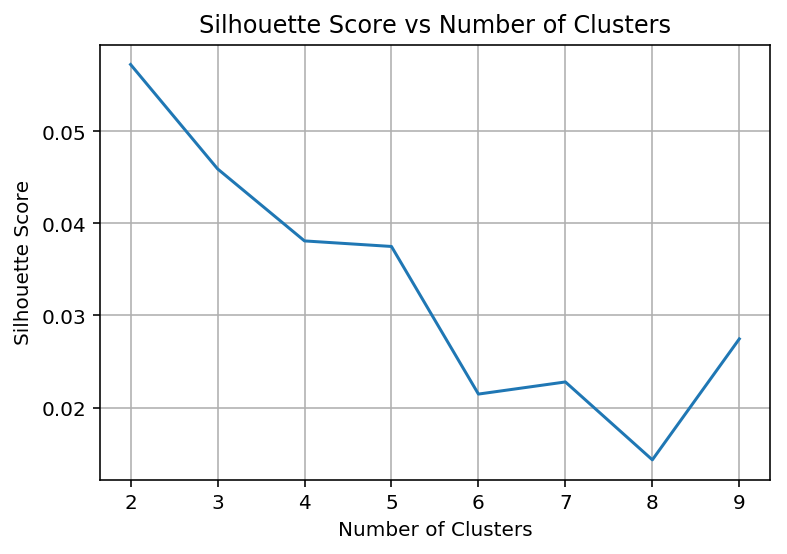

In [11]:
## Scoring Kmeans

## Running kmeans
def run_kmeans(data, n):
    kmeans = KMeans(n_clusters=n, random_state=0, n_jobs=-1).fit(data)
    
    return silhouette_score(data, kmeans.labels_)


## Finds the opitmal k value
def find_k(data, k):
    sil_scores = []
    for i in range(2, k):
        scores = (run_kmeans(data, i))
        sil_scores.append(scores)
        
    return sil_scores 

sils = find_k(X, 10)

plt.title("Silhouette Score vs Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.grid()
plt.plot(range(2, len(sils)+2), sils)

#### Hierarchical Clustering

In [21]:
def high_clustering(data, sample_size, dist_measure='cosine', plot='yes'):

    ## Selecting n random customers to look at
    trimmed_data = np.random.choice(range(data.shape[0]), sample_size)
    X = data.iloc[trimmed_data]

    ## Get vector distances (can be different measures) and squaring array
    Y = pdist(X, 'cosine')
    squareY = squareform(Y)

    ## Creates the linkage matrix with 
    return linkage(squareY, 'average')

## Plot the dendrogram
def plot_dendro(Z, labels, orient='top', thresh=None, font_s=20):
    fig = plt.figure(figsize=(25, 20))
    dn = dendrogram(Z)

    ## Grabbing the labels for each leaf
    section = np.array(dn["ivl"]).astype(int)
    lbls = labels[section]
    
    dn = dendrogram(Z, 
                    orientation=orient,
                    color_threshold=thresh,
                    labels=lbls,
                    leaf_font_size=font_s)
    plt.ylabel('Threshold')
    plt.xlabel('User')
    plt.title('User Ingredient Frequency Dendrogram')
    plt.show()

/Users/nschumacher/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


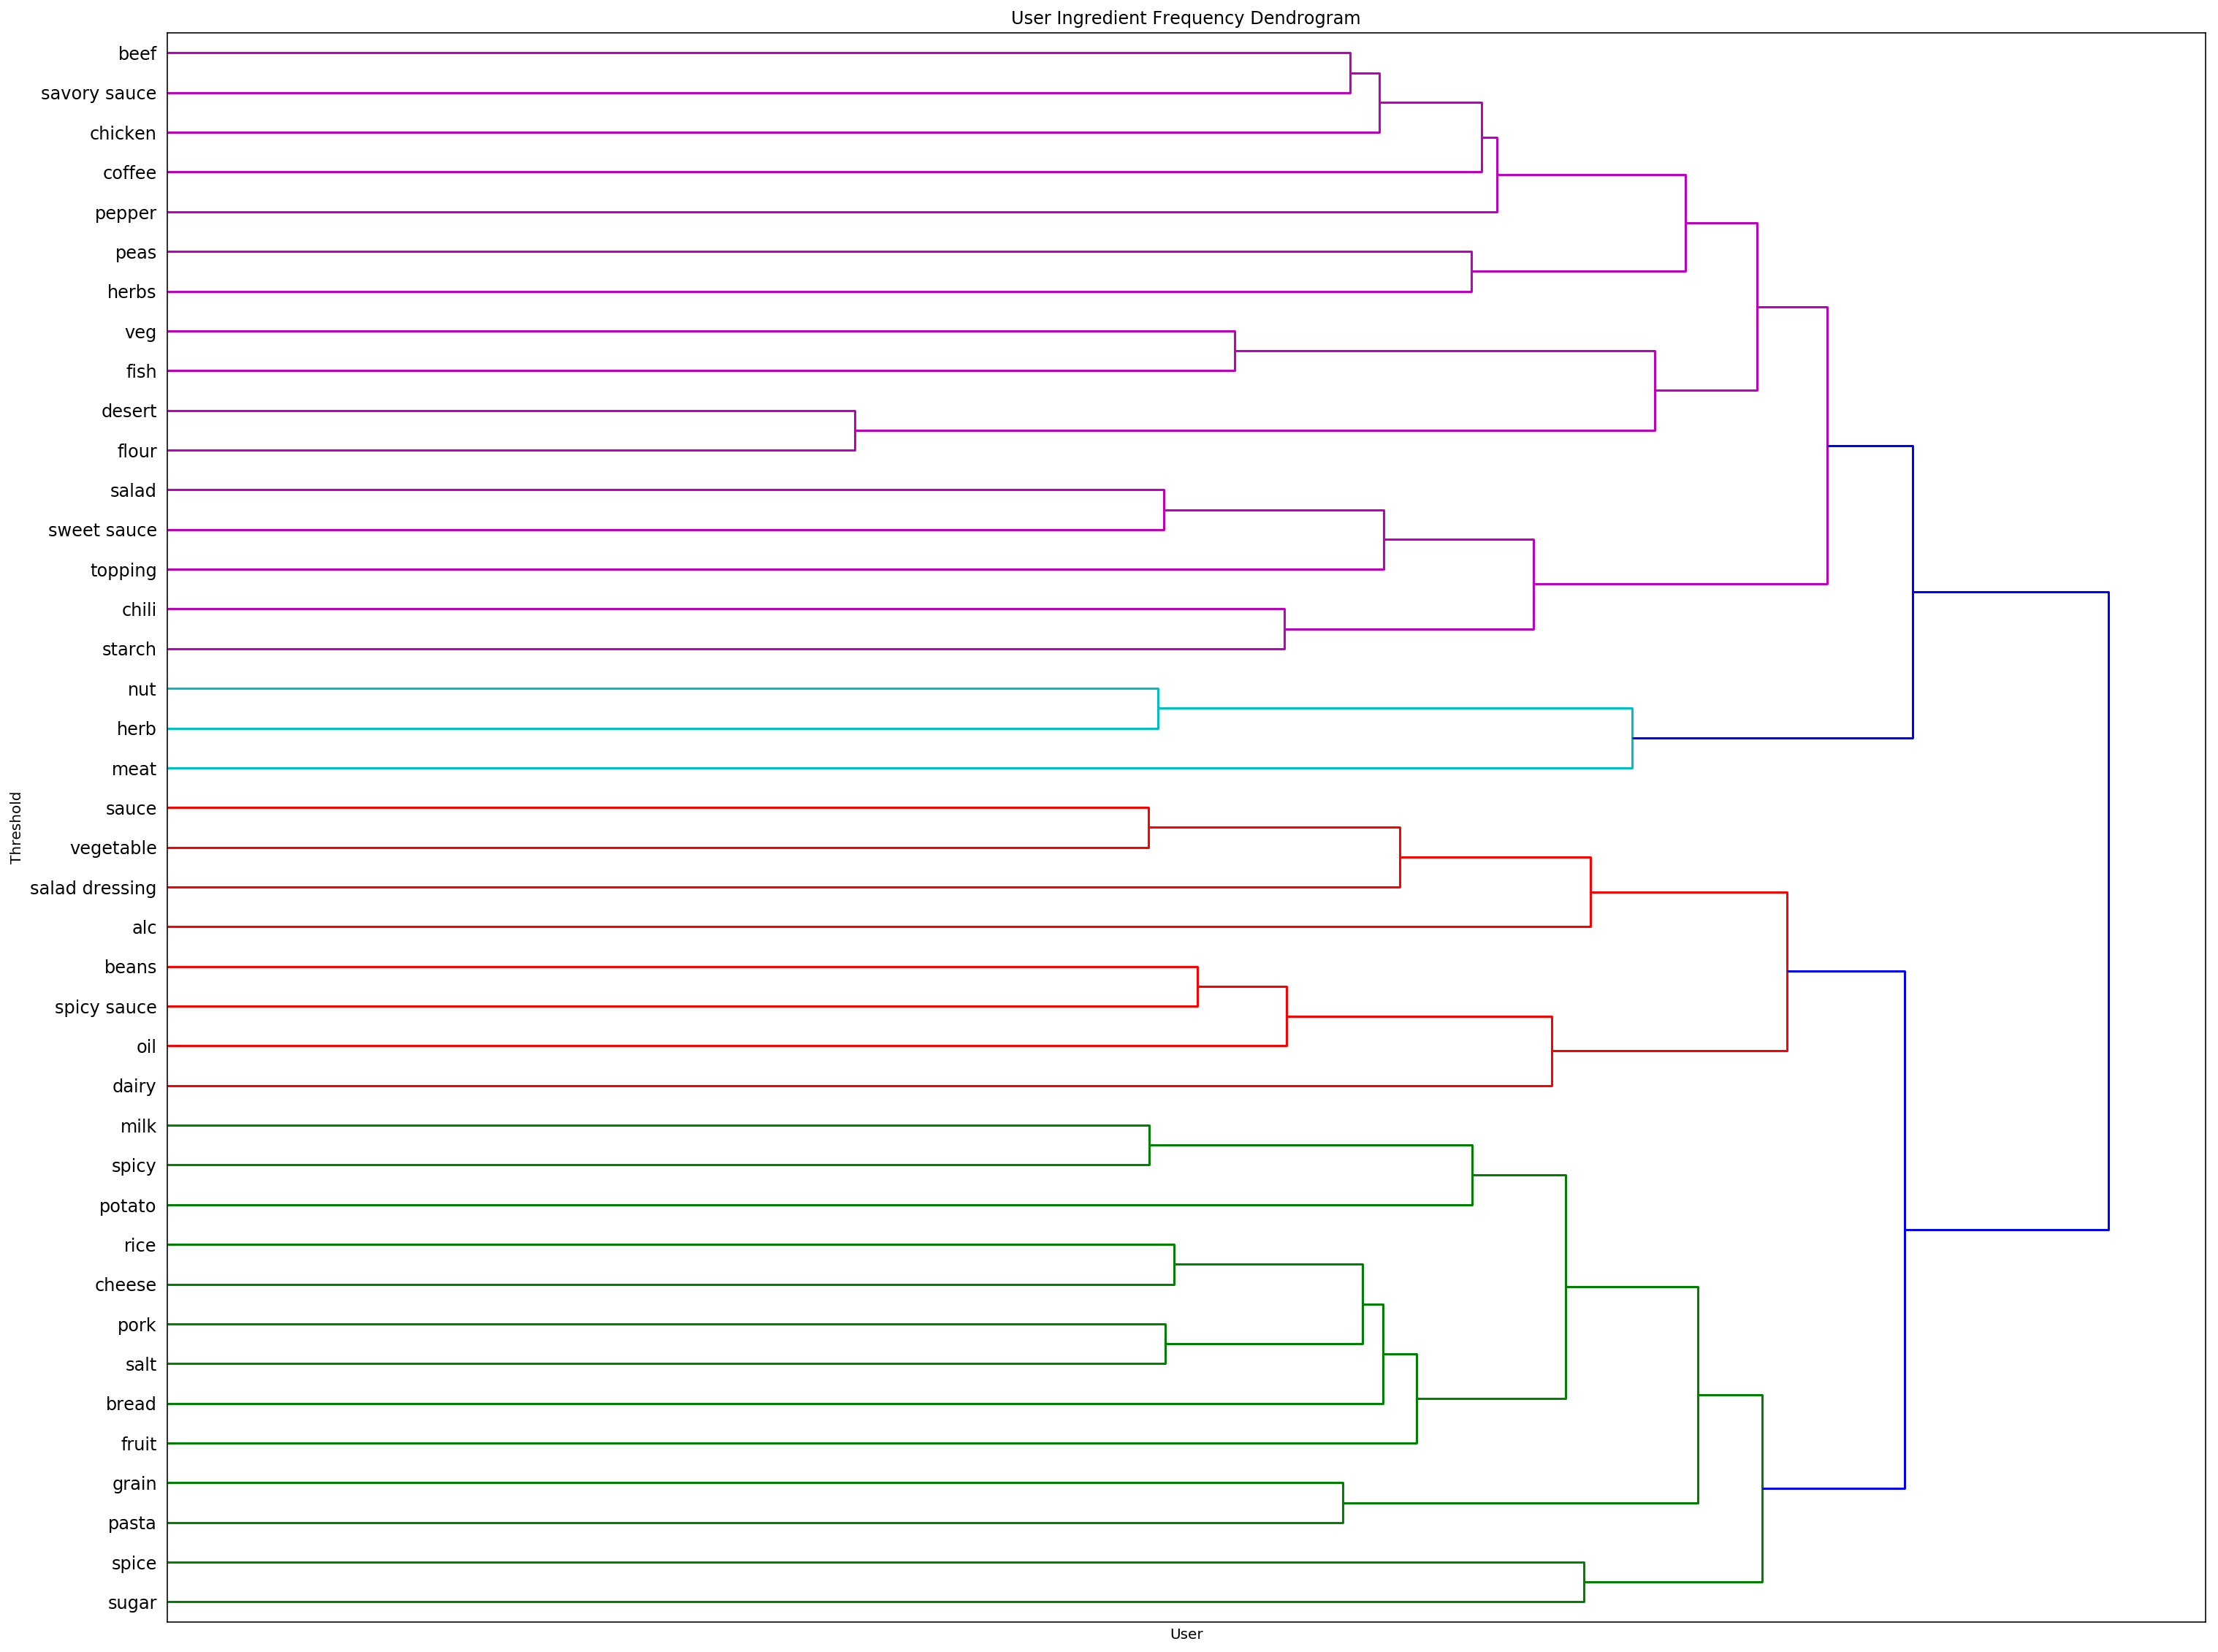

In [24]:
linkage1 = high_clustering(top_ing_f, 40)
plot_dendro(linkage1, top_ing_f.columns, orient='right', thresh=1.9, font_s=12)